In [1]:
import sys
import platform
import src.data.reader as rd
from pathlib import PurePath
from multiprocessing import cpu_count
from src.utils.utils import *

print('Python %s on %s' % (sys.version, sys.platform))

pdir = get_relative_project_dir('FinML', partial=False)
# for notebook references
sys.path.extend([pdir])
print(pdir)

data_dir = pdir / 'data'
data_raw_dir = data_dir / 'raw'
data_interim_dir = data_dir / 'interim'
data_processed_dir = data_dir / 'processed'
file_name = 'IVE_tickbidask'

Python 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] on darwin
/Users/scottblunsden/Programs/FinML


In [2]:
# Uncomment out to read from a raw data and save to a parquet file
# some code to download from internet goes here
#reader = rd.Reader()
#txt_file_name = file_name + '.txt'
#infp = PurePath(data_raw_dir / txt_file_name)
#df = reader.read_kibot_ticks(infp)

#parq_file_name = file_name+'.parq'
#outfp = PurePath(data_raw_dir / parq_file_name)

# Save file to parquet
#df.to_parquet(outfp)


In [3]:
# Load from parquet
parq_file_name = file_name + '.parq'
infp = PurePath(data_raw_dir / parq_file_name)
df = pd.read_parquet(infp)


/Users/scottblunsden/anaconda3/envs/FinML/lib/python3.6/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/Users/scottblunsden/anaconda3/envs/FinML/lib/python3.6/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/Users/scottblunsden/anaconda3/envs/FinML/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [4]:
import src.features.datacleaner as dc

data_cleaner = dc.DataCleaner()

df = data_cleaner.remove_outliers(df, 'price')
df = df.resample('1T').median().drop_duplicates().dropna()

In [5]:
import src.features.bars as bar
import src.features.labeller as lab

bars = bar.Bars()
dbars = bars.dollar_bar_df(df, 'dv', 10_000).drop_duplicates().dropna()

close = dbars.price.copy()
labeller = lab.Labeller()
dailyVol = labeller.getDailyVol(close).dropna()


  0%|          | 0/564513 [00:00<?, ?it/s]

 20%|██        | 113016/564513 [00:00<00:00, 1130158.38it/s]

 40%|████      | 226390/564513 [00:00<00:00, 1131226.78it/s]

 58%|█████▊    | 329161/564513 [00:00<00:00, 1098043.32it/s]

 80%|███████▉  | 448825/564513 [00:00<00:00, 1125872.63it/s]

100%|██████████| 564513/564513 [00:00<00:00, 1158352.79it/s]

In [6]:
import src.features.indicators.crossover as cross
crossover = cross.MACrossover()

fast_window = 3
slow_window = 7


side = crossover.get_side(close, fast_window, slow_window)


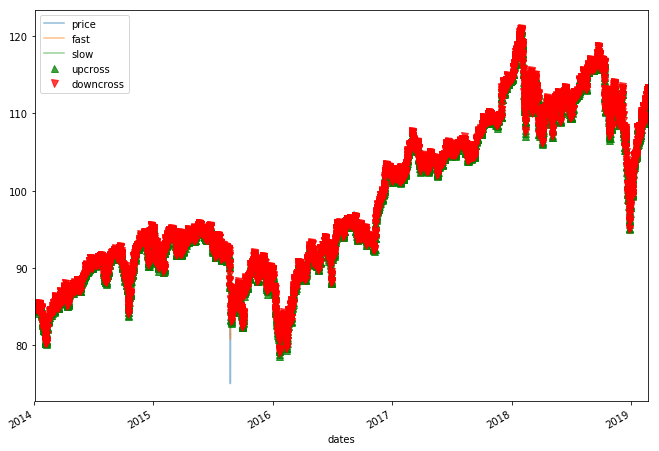

In [7]:
import matplotlib.pyplot as plt

close_df = crossover.close_df(close, fast_window, slow_window)
up = crossover.get_up_cross(close_df)
down = crossover.get_down_cross(close_df)

f, ax = plt.subplots(figsize=(11,8))

close_df.loc['2014':].plot(ax=ax, alpha=.5)
up.loc['2014':].plot(ax=ax,ls='',marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='g')
down.loc['2014':].plot(ax=ax,ls='',marker='v', markersize=7, 
                       alpha=0.75, label='downcross', color='r')

ax.legend()

In [8]:
tEvents = labeller.getTEvents(close_df['price'], h=dailyVol.mean())
t1 = labeller.addVerticalBarrier(tEvents, close_df['price'], numDays=1)

target = dailyVol

# Run in single-threaded mode on Windows

if platform.system() == "Windows":
    cpus = 1
else:
    cpus = cpu_count() - 1

minRet = .01 
ptsl=[1, 2]

ma_events = labeller.getEvents(close_df['price'], tEvents, ptsl, target, minRet, cpus, t1=t1, side=side)

ma_side = ma_events.dropna().side
ma_bins = labeller.getBinsNew(ma_events, close_df['price'], t1).dropna()

Xx = pd.merge_asof(ma_bins, side.to_frame().rename(columns={0:'side'}),
                   left_index=True, right_index=True, direction='forward')

data_processed_dir = data_dir / 'processed'
parq_file_name = file_name + '_crossover_train_test.parq'

outfp = PurePath(data_processed_dir / parq_file_name)

Xx.to_parquet(outfp)



  0%|          | 0/499250 [00:00<?, ?it/s]

  0%|          | 183/499250 [00:00<04:32, 1828.63it/s]

  0%|          | 629/499250 [00:00<03:44, 2221.64it/s]

  0%|          | 1154/499250 [00:00<03:05, 2686.26it/s]

  0%|          | 1703/499250 [00:00<02:36, 3172.00it/s]

  0%|          | 2255/499250 [00:00<02:16, 3635.02it/s]

  1%|          | 2821/499250 [00:00<02:01, 4071.97it/s]

  1%|          | 3414/499250 [00:00<01:50, 4492.12it/s]

  1%|          | 3915/499250 [00:00<01:48, 4566.74it/s]

  1%|          | 4548/499250 [00:00<01:39, 4982.30it/s]

  1%|          | 5183/499250 [00:01<01:32, 5325.77it/s]

  1%|          | 5825/499250 [00:01<01:27, 5610.41it/s]

  1%|▏         | 6437/499250 [00:01<01:25, 5751.68it/s]

  1%|▏         | 7046/499250 [00:01<01:24, 5847.28it/s]

  2%|▏         | 7761/499250 [00:01<01:19, 6184.21it/s]

  2%|▏         | 8395/499250 [00:01<01:19, 6211.52it/s]

  2%|▏         | 9147/499250 [00:01<01:14, 6552.06it/s]

  2%|▏         | 9815/499250 [00:01<01:15, 6491.50it/s]

  2%|▏         | 10473/499250 [00:01<01:15, 6493.72it/s]

  2%|▏         | 11129/499250 [00:01<01:17, 6296.25it/s]

  2%|▏         | 11765/499250 [00:02<01:21, 5987.78it/s]

  2%|▏         | 12371/499250 [00:02<01:22, 5879.05it/s]

  3%|▎         | 12965/499250 [00:02<01:27, 5548.20it/s]

  3%|▎         | 13528/499250 [00:02<01:28, 5490.66it/s]

  3%|▎         | 14118/499250 [00:02<01:26, 5606.91it/s]

  3%|▎         | 14723/499250 [00:02<01:24, 5730.35it/s]

  3%|▎         | 15306/499250 [00:02<01:24, 5754.68it/s]

  3%|▎         | 16007/499250 [00:02<01:19, 6081.29it/s]

  3%|▎         | 16707/499250 [00:02<01:16, 6328.80it/s]

  3%|▎         | 17357/499250 [00:02<01:15, 6377.10it/s]

  4%|▎         | 18000/499250 [00:03<01:15, 6356.74it/s]

  4%|▎         | 18670/499250 [00:03<01:14, 6455.06it/s]

  4%|▍         | 19419/499250 [00:03<01:11, 6733.03it/s]

  4%|▍         | 20201/499250 [00:03<01:08, 7025.14it/s]

  4%|▍         | 20927/499250 [00:03<01:07, 7092.55it/s]

  4%|▍         | 21642/499250 [00:03<01:08, 6972.51it/s]

  4%|▍         | 22344/499250 [00:03<01:09, 6897.68it/s]

  5%|▍         | 23037/499250 [00:03<01:10, 6754.17it/s]

  5%|▍         | 23716/499250 [00:03<01:11, 6670.33it/s]

  5%|▍         | 24389/499250 [00:04<01:11, 6686.28it/s]

  5%|▌         | 25060/499250 [00:04<01:13, 6473.62it/s]

  5%|▌         | 25710/499250 [00:04<01:15, 6233.32it/s]

  5%|▌         | 26338/499250 [00:04<01:16, 6191.34it/s]

  5%|▌         | 26960/499250 [00:04<01:17, 6065.30it/s]

  6%|▌         | 27594/499250 [00:04<01:16, 6144.03it/s]

  6%|▌         | 28211/499250 [00:04<01:16, 6149.72it/s]

  6%|▌         | 28828/499250 [00:04<01:16, 6133.25it/s]

  6%|▌         | 29443/499250 [00:04<01:17, 6078.15it/s]

  6%|▌         | 30065/499250 [00:04<01:16, 6118.11it/s]

  6%|▌         | 30678/499250 [00:05<01:16, 6100.45it/s]

  6%|▋         | 31289/499250 [00:05<01:18, 5982.65it/s]

  6%|▋         | 31922/499250 [00:05<01:16, 6081.72it/s]

  7%|▋         | 32590/499250 [00:05<01:14, 6249.62it/s]

  7%|▋         | 33224/499250 [00:05<01:14, 6274.39it/s]

  7%|▋         | 33891/499250 [00:05<01:12, 6386.02it/s]

  7%|▋         | 34547/499250 [00:05<01:12, 6436.32it/s]

  7%|▋         | 35205/499250 [00:05<01:11, 6477.20it/s]

  7%|▋         | 35854/499250 [00:05<01:11, 6446.53it/s]

  7%|▋         | 36514/499250 [00:05<01:11, 6487.35it/s]

  7%|▋         | 37164/499250 [00:06<01:11, 6461.04it/s]

  8%|▊         | 37811/499250 [00:06<01:11, 6438.26it/s]

  8%|▊         | 38456/499250 [00:06<01:12, 6327.91it/s]

  8%|▊         | 39090/499250 [00:06<01:16, 6009.76it/s]

  8%|▊         | 39723/499250 [00:06<01:15, 6099.94it/s]

  8%|▊         | 40336/499250 [00:06<01:16, 6012.16it/s]

  8%|▊         | 40984/499250 [00:06<01:14, 6144.66it/s]

  8%|▊         | 41683/499250 [00:06<01:11, 6374.14it/s]

  8%|▊         | 42412/499250 [00:06<01:08, 6621.86it/s]

  9%|▊         | 43136/499250 [00:06<01:07, 6794.51it/s]

  9%|▉         | 43839/499250 [00:07<01:06, 6861.01it/s]

  9%|▉         | 44552/499250 [00:07<01:05, 6937.75it/s]

  9%|▉         | 45249/499250 [00:07<01:05, 6937.79it/s]

  9%|▉         | 45945/499250 [00:07<01:08, 6585.48it/s]

  9%|▉         | 46609/499250 [00:07<01:11, 6356.53it/s]

  9%|▉         | 47254/499250 [00:07<01:10, 6383.84it/s]

 10%|▉         | 47903/499250 [00:07<01:10, 6414.57it/s]

 10%|▉         | 48585/499250 [00:07<01:09, 6530.04it/s]

 10%|▉         | 49267/499250 [00:07<01:08, 6614.00it/s]

 10%|█         | 49934/499250 [00:08<01:07, 6629.89it/s]

 10%|█         | 50599/499250 [00:08<01:08, 6593.35it/s]

 10%|█         | 51260/499250 [00:08<01:08, 6541.47it/s]

 10%|█         | 51948/499250 [00:08<01:07, 6635.54it/s]

 11%|█         | 52613/499250 [00:08<01:07, 6612.85it/s]

 11%|█         | 53275/499250 [00:08<01:07, 6598.75it/s]

 11%|█         | 53936/499250 [00:08<01:07, 6588.50it/s]

 11%|█         | 54596/499250 [00:08<01:07, 6585.66it/s]

 11%|█         | 55255/499250 [00:08<01:08, 6512.36it/s]

 11%|█         | 55907/499250 [00:08<01:08, 6450.11it/s]

 11%|█▏        | 56553/499250 [00:09<01:09, 6372.26it/s]

 11%|█▏        | 57191/499250 [00:09<01:09, 6339.57it/s]

 12%|█▏        | 57830/499250 [00:09<01:09, 6352.55it/s]

 12%|█▏        | 58466/499250 [00:09<01:09, 6341.49it/s]

 12%|█▏        | 59101/499250 [00:09<01:09, 6340.30it/s]

 12%|█▏        | 59736/499250 [00:09<01:09, 6298.10it/s]

 12%|█▏        | 60366/499250 [00:09<01:10, 6238.96it/s]

 12%|█▏        | 60991/499250 [00:09<01:10, 6208.23it/s]

 12%|█▏        | 61643/499250 [00:09<01:09, 6298.42it/s]

 12%|█▏        | 62274/499250 [00:09<01:09, 6295.84it/s]

 13%|█▎        | 62904/499250 [00:10<01:10, 6196.80it/s]

 13%|█▎        | 63525/499250 [00:10<01:13, 5933.61it/s]

 13%|█▎        | 64122/499250 [00:10<01:14, 5870.63it/s]

 13%|█▎        | 64763/499250 [00:10<01:12, 6020.32it/s]

 13%|█▎        | 65368/499250 [00:10<01:13, 5927.63it/s]

 13%|█▎        | 65963/499250 [00:10<01:13, 5923.58it/s]

 13%|█▎        | 66599/499250 [00:10<01:11, 6045.76it/s]

 13%|█▎        | 67206/499250 [00:10<01:12, 5970.69it/s]

 14%|█▎        | 67805/499250 [00:10<01:12, 5914.34it/s]

 14%|█▎        | 68398/499250 [00:10<01:13, 5862.96it/s]

 14%|█▍        | 69058/499250 [00:11<01:10, 6064.37it/s]

 14%|█▍        | 69673/499250 [00:11<01:10, 6089.16it/s]

 14%|█▍        | 70291/499250 [00:11<01:10, 6114.79it/s]

 14%|█▍        | 70904/499250 [00:11<01:10, 6095.64it/s]

 14%|█▍        | 71530/499250 [00:11<01:09, 6143.97it/s]

 14%|█▍        | 72146/499250 [00:11<01:09, 6145.97it/s]

 15%|█▍        | 72762/499250 [00:11<01:09, 6123.39it/s]

 15%|█▍        | 73455/499250 [00:11<01:07, 6343.59it/s]

 15%|█▍        | 74139/499250 [00:11<01:05, 6482.92it/s]

 15%|█▍        | 74825/499250 [00:11<01:04, 6589.18it/s]

 15%|█▌        | 75486/499250 [00:12<01:04, 6543.74it/s]

 15%|█▌        | 76142/499250 [00:12<01:06, 6333.52it/s]

 15%|█▌        | 76778/499250 [00:12<01:08, 6142.47it/s]

 16%|█▌        | 77396/499250 [00:12<01:10, 6025.64it/s]

 16%|█▌        | 78002/499250 [00:12<01:10, 5957.10it/s]

 16%|█▌        | 78600/499250 [00:12<01:10, 5934.60it/s]

 16%|█▌        | 79195/499250 [00:12<01:11, 5879.13it/s]

 16%|█▌        | 79785/499250 [00:12<01:12, 5746.83it/s]

 16%|█▌        | 80375/499250 [00:12<01:12, 5790.44it/s]

 16%|█▌        | 80984/499250 [00:13<01:11, 5876.60it/s]

 16%|█▋        | 81591/499250 [00:13<01:10, 5928.49it/s]

 16%|█▋        | 82185/499250 [00:13<01:10, 5887.06it/s]

 17%|█▋        | 82799/499250 [00:13<01:09, 5959.62it/s]

 17%|█▋        | 83396/499250 [00:13<01:10, 5907.12it/s]

 17%|█▋        | 83988/499250 [00:13<01:11, 5835.40it/s]

 17%|█▋        | 84592/499250 [00:13<01:10, 5893.94it/s]

 17%|█▋        | 85232/499250 [00:13<01:08, 6036.88it/s]

 17%|█▋        | 85837/499250 [00:13<01:08, 6000.11it/s]

 17%|█▋        | 86445/499250 [00:13<01:08, 6022.05it/s]

 17%|█▋        | 87081/499250 [00:14<01:07, 6118.63it/s]

 18%|█▊        | 87706/499250 [00:14<01:06, 6155.02it/s]

 18%|█▊        | 88323/499250 [00:14<01:07, 6102.81it/s]

 18%|█▊        | 88934/499250 [00:14<01:08, 5993.05it/s]

 18%|█▊        | 89549/499250 [00:14<01:07, 6039.07it/s]

 18%|█▊        | 90154/499250 [00:14<01:08, 5984.91it/s]

 18%|█▊        | 90754/499250 [00:14<01:08, 5921.83it/s]

 18%|█▊        | 91347/499250 [00:14<01:09, 5904.72it/s]

 18%|█▊        | 91938/499250 [00:14<01:09, 5869.40it/s]

 19%|█▊        | 92526/499250 [00:14<01:09, 5856.31it/s]

 19%|█▊        | 93141/499250 [00:15<01:08, 5941.00it/s]

 19%|█▉        | 93779/499250 [00:15<01:06, 6065.03it/s]

 19%|█▉        | 94401/499250 [00:15<01:06, 6108.77it/s]

 19%|█▉        | 95040/499250 [00:15<01:05, 6188.80it/s]

 19%|█▉        | 95672/499250 [00:15<01:04, 6226.76it/s]

 19%|█▉        | 96296/499250 [00:15<01:05, 6141.45it/s]

 19%|█▉        | 96911/499250 [00:15<01:06, 6064.31it/s]

 20%|█▉        | 97519/499250 [00:15<01:07, 5977.50it/s]

 20%|█▉        | 98118/499250 [00:15<01:07, 5956.62it/s]

 20%|█▉        | 98715/499250 [00:15<01:07, 5940.37it/s]

 20%|█▉        | 99310/499250 [00:16<01:08, 5872.47it/s]

 20%|██        | 99898/499250 [00:16<01:08, 5841.78it/s]

 20%|██        | 100500/499250 [00:16<01:07, 5893.00it/s]

 20%|██        | 101140/499250 [00:16<01:05, 6034.60it/s]

 20%|██        | 101779/499250 [00:16<01:04, 6134.74it/s]

 21%|██        | 102394/499250 [00:16<01:05, 6038.15it/s]

 21%|██        | 102999/499250 [00:16<01:06, 5935.28it/s]

 21%|██        | 103653/499250 [00:16<01:04, 6099.08it/s]

 21%|██        | 104265/499250 [00:16<01:07, 5849.59it/s]

 21%|██        | 104854/499250 [00:17<01:08, 5747.96it/s]

 21%|██        | 105452/499250 [00:17<01:07, 5808.08it/s]

 21%|██        | 106035/499250 [00:17<01:08, 5729.66it/s]

 21%|██▏       | 106668/499250 [00:17<01:06, 5895.78it/s]

 21%|██▏       | 107261/499250 [00:17<01:07, 5839.16it/s]

 22%|██▏       | 107847/499250 [00:17<01:08, 5699.15it/s]

 22%|██▏       | 108419/499250 [00:17<01:08, 5679.20it/s]

 22%|██▏       | 109005/499250 [00:17<01:08, 5732.04it/s]

 22%|██▏       | 109698/499250 [00:17<01:04, 6044.55it/s]

 22%|██▏       | 110347/499250 [00:17<01:03, 6170.29it/s]

 22%|██▏       | 111007/499250 [00:18<01:01, 6292.42it/s]

 22%|██▏       | 111640/499250 [00:18<01:02, 6232.09it/s]

 22%|██▏       | 112284/499250 [00:18<01:01, 6292.23it/s]

 23%|██▎       | 112920/499250 [00:18<01:01, 6308.73it/s]

 23%|██▎       | 113586/499250 [00:18<01:00, 6407.10it/s]

 23%|██▎       | 114229/499250 [00:18<01:00, 6403.28it/s]

 23%|██▎       | 114873/499250 [00:18<00:59, 6412.30it/s]

 23%|██▎       | 115515/499250 [00:18<01:03, 6051.13it/s]

 23%|██▎       | 116125/499250 [00:18<01:05, 5894.22it/s]

 23%|██▎       | 116719/499250 [00:18<01:05, 5868.74it/s]

 23%|██▎       | 117309/499250 [00:19<01:07, 5683.95it/s]

 24%|██▎       | 117881/499250 [00:19<01:09, 5525.81it/s]

 24%|██▎       | 118519/499250 [00:19<01:06, 5755.92it/s]

 24%|██▍       | 119145/499250 [00:19<01:04, 5897.38it/s]

 24%|██▍       | 119763/499250 [00:19<01:03, 5977.65it/s]

 24%|██▍       | 120364/499250 [00:19<01:05, 5774.03it/s]

 24%|██▍       | 120946/499250 [00:19<01:06, 5695.99it/s]

 24%|██▍       | 121552/499250 [00:19<01:05, 5799.51it/s]

 24%|██▍       | 122135/499250 [00:19<01:06, 5645.10it/s]

 25%|██▍       | 122703/499250 [00:20<01:08, 5498.43it/s]

 25%|██▍       | 123378/499250 [00:20<01:04, 5820.47it/s]

 25%|██▍       | 123975/499250 [00:20<01:03, 5863.68it/s]

 25%|██▍       | 124567/499250 [00:20<01:05, 5726.08it/s]

 25%|██▌       | 125167/499250 [00:20<01:04, 5804.96it/s]

 25%|██▌       | 125751/499250 [00:20<01:04, 5794.48it/s]

 25%|██▌       | 126333/499250 [00:20<01:04, 5747.01it/s]

 25%|██▌       | 126929/499250 [00:20<01:04, 5806.26it/s]

 26%|██▌       | 127515/499250 [00:20<01:03, 5820.78it/s]

 26%|██▌       | 128122/499250 [00:20<01:02, 5892.84it/s]

 26%|██▌       | 128724/499250 [00:21<01:02, 5930.05it/s]

 26%|██▌       | 129361/499250 [00:21<01:01, 6055.26it/s]

 26%|██▌       | 129992/499250 [00:21<01:00, 6127.16it/s]

 26%|██▌       | 130606/499250 [00:21<01:00, 6072.29it/s]

 26%|██▋       | 131215/499250 [00:21<01:01, 5992.25it/s]

 26%|██▋       | 131816/499250 [00:21<01:02, 5922.39it/s]

 27%|██▋       | 132409/499250 [00:21<01:02, 5852.92it/s]

 27%|██▋       | 132995/499250 [00:21<01:03, 5795.61it/s]

 27%|██▋       | 133581/499250 [00:21<01:02, 5812.98it/s]

 27%|██▋       | 134163/499250 [00:21<01:03, 5753.43it/s]

 27%|██▋       | 134756/499250 [00:22<01:02, 5803.68it/s]

 27%|██▋       | 135338/499250 [00:22<01:02, 5807.96it/s]

 27%|██▋       | 135920/499250 [00:22<01:02, 5775.50it/s]

 27%|██▋       | 136498/499250 [00:22<01:03, 5755.50it/s]

 27%|██▋       | 137074/499250 [00:22<01:06, 5473.31it/s]

 28%|██▊       | 137651/499250 [00:22<01:05, 5558.08it/s]

 28%|██▊       | 138224/499250 [00:22<01:04, 5604.99it/s]

 28%|██▊       | 138825/499250 [00:22<01:03, 5719.24it/s]

 28%|██▊       | 139465/499250 [00:22<01:00, 5906.98it/s]

 28%|██▊       | 140059/499250 [00:23<01:01, 5879.59it/s]

 28%|██▊       | 140649/499250 [00:23<01:00, 5884.43it/s]

 28%|██▊       | 141239/499250 [00:23<01:04, 5520.21it/s]

 28%|██▊       | 141857/499250 [00:23<01:02, 5700.48it/s]

 29%|██▊       | 142473/499250 [00:23<01:01, 5830.71it/s]

 29%|██▊       | 143061/499250 [00:23<01:03, 5643.93it/s]

 29%|██▉       | 143630/499250 [00:23<01:03, 5617.63it/s]

 29%|██▉       | 144210/499250 [00:23<01:02, 5669.46it/s]

 29%|██▉       | 144787/499250 [00:23<01:02, 5697.02it/s]

 29%|██▉       | 145359/499250 [00:23<01:02, 5683.24it/s]

 29%|██▉       | 145930/499250 [00:24<01:02, 5688.69it/s]

 29%|██▉       | 146504/499250 [00:24<01:01, 5701.15it/s]

 29%|██▉       | 147097/499250 [00:24<01:01, 5766.48it/s]

 30%|██▉       | 147675/499250 [00:24<01:00, 5764.09it/s]

 30%|██▉       | 148260/499250 [00:24<01:00, 5786.69it/s]

 30%|██▉       | 148840/499250 [00:24<01:00, 5788.36it/s]

 30%|██▉       | 149423/499250 [00:24<01:00, 5800.01it/s]

 30%|███       | 150013/499250 [00:24<00:59, 5827.18it/s]

 30%|███       | 150601/499250 [00:24<00:59, 5840.76it/s]

 30%|███       | 151186/499250 [00:24<01:03, 5478.08it/s]

 30%|███       | 151758/499250 [00:25<01:02, 5547.93it/s]

 31%|███       | 152332/499250 [00:25<01:01, 5598.28it/s]

 31%|███       | 152914/499250 [00:25<01:01, 5661.80it/s]

 31%|███       | 153525/499250 [00:25<00:59, 5787.49it/s]

 31%|███       | 154158/499250 [00:25<00:58, 5940.11it/s]

 31%|███       | 154795/499250 [00:25<00:56, 6062.51it/s]

 31%|███       | 155433/499250 [00:25<00:55, 6152.80it/s]

 31%|███▏      | 156060/499250 [00:25<00:55, 6185.41it/s]

 31%|███▏      | 156680/499250 [00:25<00:56, 6083.41it/s]

 32%|███▏      | 157329/499250 [00:25<00:55, 6198.34it/s]

 32%|███▏      | 157951/499250 [00:26<00:55, 6121.45it/s]

 32%|███▏      | 158565/499250 [00:26<00:56, 5978.55it/s]

 32%|███▏      | 159165/499250 [00:26<00:57, 5935.41it/s]

 32%|███▏      | 159760/499250 [00:26<00:58, 5829.89it/s]

 32%|███▏      | 160345/499250 [00:26<00:58, 5765.41it/s]

 32%|███▏      | 160930/499250 [00:26<00:58, 5785.55it/s]

 32%|███▏      | 161516/499250 [00:26<00:58, 5807.07it/s]

 32%|███▏      | 162098/499250 [00:26<00:58, 5808.83it/s]

 33%|███▎      | 162683/499250 [00:26<00:57, 5820.86it/s]

 33%|███▎      | 163266/499250 [00:27<00:57, 5809.87it/s]

 33%|███▎      | 163848/499250 [00:27<00:57, 5799.81it/s]

 33%|███▎      | 164436/499250 [00:27<00:57, 5821.61it/s]

 33%|███▎      | 165048/499250 [00:27<00:56, 5906.76it/s]

 33%|███▎      | 165640/499250 [00:27<00:56, 5854.59it/s]

 33%|███▎      | 166226/499250 [00:27<00:57, 5756.91it/s]

 33%|███▎      | 166813/499250 [00:27<00:57, 5789.71it/s]

 34%|███▎      | 167440/499250 [00:27<00:56, 5924.49it/s]

 34%|███▎      | 168040/499250 [00:27<00:55, 5946.85it/s]

 34%|███▍      | 168742/499250 [00:27<00:53, 6230.52it/s]

 34%|███▍      | 169451/499250 [00:28<00:51, 6461.29it/s]

 34%|███▍      | 170103/499250 [00:28<00:52, 6297.24it/s]

 34%|███▍      | 170738/499250 [00:28<00:55, 5920.98it/s]

 34%|███▍      | 171392/499250 [00:28<00:53, 6093.85it/s]

 34%|███▍      | 172009/499250 [00:28<00:54, 6004.53it/s]

 35%|███▍      | 172658/499250 [00:28<00:53, 6139.82it/s]

 35%|███▍      | 173277/499250 [00:28<00:54, 5943.72it/s]

 35%|███▍      | 173876/499250 [00:28<00:57, 5693.89it/s]

 35%|███▍      | 174451/499250 [00:28<00:59, 5448.87it/s]

 35%|███▌      | 175002/499250 [00:29<01:00, 5337.52it/s]

 35%|███▌      | 175649/499250 [00:29<00:57, 5632.61it/s]

 35%|███▌      | 176239/499250 [00:29<00:56, 5708.19it/s]

 35%|███▌      | 176842/499250 [00:29<00:55, 5798.99it/s]

 36%|███▌      | 177427/499250 [00:29<00:55, 5796.99it/s]

 36%|███▌      | 178037/499250 [00:29<00:54, 5883.34it/s]

 36%|███▌      | 178656/499250 [00:29<00:53, 5970.44it/s]

 36%|███▌      | 179302/499250 [00:29<00:52, 6107.74it/s]

 36%|███▌      | 179992/499250 [00:29<00:50, 6325.41it/s]

 36%|███▌      | 180704/499250 [00:29<00:48, 6542.62it/s]

 36%|███▋      | 181474/499250 [00:30<00:46, 6850.86it/s]

 36%|███▋      | 182166/499250 [00:30<00:47, 6673.83it/s]

 37%|███▋      | 182840/499250 [00:30<00:48, 6526.48it/s]

 37%|███▋      | 183498/499250 [00:30<00:49, 6430.20it/s]

 37%|███▋      | 184145/499250 [00:30<00:49, 6387.56it/s]

 37%|███▋      | 184787/499250 [00:30<00:50, 6226.39it/s]

 37%|███▋      | 185413/499250 [00:30<00:51, 6113.76it/s]

 37%|███▋      | 186027/499250 [00:30<00:51, 6059.96it/s]

 37%|███▋      | 186635/499250 [00:30<00:52, 5998.74it/s]

 38%|███▊      | 187237/499250 [00:30<00:52, 5999.99it/s]

 38%|███▊      | 187846/499250 [00:31<00:51, 6024.98it/s]

 38%|███▊      | 188465/499250 [00:31<00:51, 6073.34it/s]

 38%|███▊      | 189073/499250 [00:31<00:51, 6071.26it/s]

 38%|███▊      | 189681/499250 [00:31<00:51, 6064.61it/s]

 38%|███▊      | 190288/499250 [00:31<00:50, 6065.02it/s]

 38%|███▊      | 190895/499250 [00:31<00:51, 6005.64it/s]

 38%|███▊      | 191504/499250 [00:31<00:51, 6030.38it/s]

 38%|███▊      | 192108/499250 [00:31<00:51, 5952.56it/s]

 39%|███▊      | 192704/499250 [00:31<00:51, 5935.39it/s]

 39%|███▊      | 193298/499250 [00:31<00:52, 5842.34it/s]

 39%|███▉      | 193883/499250 [00:32<00:53, 5731.71it/s]

 39%|███▉      | 194610/499250 [00:32<00:49, 6117.19it/s]

 39%|███▉      | 195240/499250 [00:32<00:49, 6170.69it/s]

 39%|███▉      | 195863/499250 [00:32<00:49, 6115.85it/s]

 39%|███▉      | 196479/499250 [00:32<00:51, 5916.39it/s]

 39%|███▉      | 197075/499250 [00:32<00:51, 5888.40it/s]

 40%|███▉      | 197667/499250 [00:32<00:54, 5548.61it/s]

 40%|███▉      | 198228/499250 [00:32<00:56, 5347.41it/s]

 40%|███▉      | 198773/499250 [00:32<00:55, 5376.44it/s]

 40%|███▉      | 199315/499250 [00:33<00:56, 5345.82it/s]

 40%|████      | 199853/499250 [00:33<00:59, 5062.18it/s]

 40%|████      | 200365/499250 [00:33<01:02, 4811.02it/s]

 40%|████      | 200853/499250 [00:33<01:03, 4699.96it/s]

 40%|████      | 201377/499250 [00:33<01:01, 4848.50it/s]

 40%|████      | 201965/499250 [00:33<00:58, 5115.77it/s]

 41%|████      | 202509/499250 [00:33<00:56, 5207.11it/s]

 41%|████      | 203064/499250 [00:33<00:55, 5303.36it/s]

 41%|████      | 203693/499250 [00:33<00:53, 5564.60it/s]

 41%|████      | 204265/499250 [00:33<00:52, 5608.95it/s]

 41%|████      | 204831/499250 [00:34<00:52, 5588.77it/s]

 41%|████      | 205439/499250 [00:34<00:51, 5727.00it/s]

 41%|████▏     | 206016/499250 [00:34<00:51, 5738.32it/s]

 41%|████▏     | 206592/499250 [00:34<00:52, 5582.19it/s]

 41%|████▏     | 207153/499250 [00:34<00:52, 5573.63it/s]

 42%|████▏     | 207721/499250 [00:34<00:52, 5603.08it/s]

 42%|████▏     | 208283/499250 [00:34<00:51, 5601.19it/s]

 42%|████▏     | 208844/499250 [00:34<00:53, 5460.42it/s]

 42%|████▏     | 209392/499250 [00:34<00:58, 4972.11it/s]

 42%|████▏     | 209899/499250 [00:35<00:57, 4993.22it/s]

 42%|████▏     | 210484/499250 [00:35<00:55, 5220.65it/s]

 42%|████▏     | 211212/499250 [00:35<00:50, 5704.72it/s]

 42%|████▏     | 211844/499250 [00:35<00:48, 5876.30it/s]

 43%|████▎     | 212446/499250 [00:35<00:49, 5823.86it/s]

 43%|████▎     | 213039/499250 [00:35<00:50, 5712.40it/s]

 43%|████▎     | 213618/499250 [00:35<00:51, 5531.93it/s]

 43%|████▎     | 214205/499250 [00:35<00:50, 5628.65it/s]

 43%|████▎     | 214787/499250 [00:35<00:50, 5682.06it/s]

 43%|████▎     | 215367/499250 [00:35<00:49, 5716.16it/s]

 43%|████▎     | 215942/499250 [00:36<00:49, 5719.41it/s]

 43%|████▎     | 216517/499250 [00:36<00:49, 5726.59it/s]

 43%|████▎     | 217091/499250 [00:36<00:49, 5716.91it/s]

 44%|████▎     | 217668/499250 [00:36<00:49, 5731.21it/s]

 44%|████▎     | 218261/499250 [00:36<00:48, 5787.15it/s]

 44%|████▍     | 218841/499250 [00:36<00:48, 5772.60it/s]

 44%|████▍     | 219426/499250 [00:36<00:48, 5795.03it/s]

 44%|████▍     | 220006/499250 [00:36<00:50, 5574.04it/s]

 44%|████▍     | 220572/499250 [00:36<00:49, 5596.99it/s]

 44%|████▍     | 221144/499250 [00:36<00:49, 5632.82it/s]

 44%|████▍     | 221709/499250 [00:37<00:49, 5637.15it/s]

 45%|████▍     | 222274/499250 [00:37<00:51, 5396.79it/s]

 45%|████▍     | 222847/499250 [00:37<00:50, 5491.34it/s]

 45%|████▍     | 223422/499250 [00:37<00:49, 5565.38it/s]

 45%|████▍     | 223999/499250 [00:37<00:48, 5625.16it/s]

 45%|████▍     | 224579/499250 [00:37<00:48, 5674.54it/s]

 45%|████▌     | 225148/499250 [00:37<00:48, 5626.26it/s]

 45%|████▌     | 225712/499250 [00:37<00:50, 5431.01it/s]

 45%|████▌     | 226292/499250 [00:37<00:49, 5536.28it/s]

 45%|████▌     | 226872/499250 [00:38<00:48, 5608.61it/s]

 46%|████▌     | 227448/499250 [00:38<00:48, 5651.52it/s]

 46%|████▌     | 228015/499250 [00:38<00:48, 5620.76it/s]

 46%|████▌     | 228635/499250 [00:38<00:46, 5782.18it/s]

 46%|████▌     | 229315/499250 [00:38<00:44, 6052.60it/s]

 46%|████▌     | 229928/499250 [00:38<00:44, 6073.80it/s]

 46%|████▌     | 230702/499250 [00:38<00:41, 6492.31it/s]

 46%|████▋     | 231406/499250 [00:38<00:40, 6646.78it/s]

 46%|████▋     | 232079/499250 [00:38<00:40, 6613.27it/s]

 47%|████▋     | 232747/499250 [00:38<00:40, 6538.12it/s]

 47%|████▋     | 233414/499250 [00:39<00:40, 6576.61it/s]

 47%|████▋     | 234075/499250 [00:39<00:40, 6523.41it/s]

 47%|████▋     | 234733/499250 [00:39<00:40, 6539.66it/s]

 47%|████▋     | 235389/499250 [00:39<00:40, 6520.74it/s]

 47%|████▋     | 236043/499250 [00:39<00:41, 6388.21it/s]

 47%|████▋     | 236684/499250 [00:39<00:41, 6310.40it/s]

 48%|████▊     | 237317/499250 [00:39<00:42, 6146.89it/s]

 48%|████▊     | 237934/499250 [00:39<00:43, 5987.32it/s]

 48%|████▊     | 238535/499250 [00:39<00:43, 5936.95it/s]

 48%|████▊     | 239142/499250 [00:39<00:43, 5975.05it/s]

 48%|████▊     | 239743/499250 [00:40<00:43, 5984.84it/s]

 48%|████▊     | 240343/499250 [00:40<00:43, 5903.66it/s]

 48%|████▊     | 240963/499250 [00:40<00:43, 5988.90it/s]

 48%|████▊     | 241569/499250 [00:40<00:42, 6009.59it/s]

 49%|████▊     | 242171/499250 [00:40<00:43, 5935.72it/s]

 49%|████▊     | 242766/499250 [00:40<00:43, 5831.40it/s]

 49%|████▊     | 243351/499250 [00:40<00:44, 5791.00it/s]

 49%|████▉     | 243949/499250 [00:40<00:43, 5845.64it/s]

 49%|████▉     | 244535/499250 [00:40<00:44, 5780.53it/s]

 49%|████▉     | 245219/499250 [00:40<00:41, 6061.44it/s]

 49%|████▉     | 245830/499250 [00:41<00:43, 5838.45it/s]

 49%|████▉     | 246419/499250 [00:41<00:44, 5658.58it/s]

 49%|████▉     | 246990/499250 [00:41<00:44, 5626.03it/s]

 50%|████▉     | 247586/499250 [00:41<00:43, 5721.08it/s]

 50%|████▉     | 248161/499250 [00:41<00:44, 5630.45it/s]

 50%|████▉     | 248727/499250 [00:41<00:46, 5435.80it/s]

 50%|████▉     | 249303/499250 [00:41<00:45, 5522.96it/s]

 50%|█████     | 249901/499250 [00:41<00:44, 5650.88it/s]

 50%|█████     | 250486/499250 [00:41<00:43, 5707.37it/s]

 50%|█████     | 251064/499250 [00:42<00:43, 5726.62it/s]

 50%|█████     | 251638/499250 [00:42<00:43, 5707.29it/s]

 51%|█████     | 252222/499250 [00:42<00:43, 5743.43it/s]

 51%|█████     | 252824/499250 [00:42<00:42, 5821.60it/s]

 51%|█████     | 253425/499250 [00:42<00:41, 5875.61it/s]

 51%|█████     | 254050/499250 [00:42<00:40, 5981.93it/s]

 51%|█████     | 254650/499250 [00:42<00:41, 5862.56it/s]

 51%|█████     | 255281/499250 [00:42<00:40, 5986.11it/s]

 51%|█████▏    | 255911/499250 [00:42<00:40, 6076.80it/s]

 51%|█████▏    | 256521/499250 [00:42<00:40, 5933.85it/s]

 52%|█████▏    | 257117/499250 [00:43<00:42, 5660.36it/s]

 52%|█████▏    | 257698/499250 [00:43<00:42, 5704.27it/s]

 52%|█████▏    | 258285/499250 [00:43<00:41, 5751.73it/s]

 52%|█████▏    | 258863/499250 [00:43<00:42, 5716.86it/s]

 52%|█████▏    | 259464/499250 [00:43<00:41, 5800.83it/s]

 52%|█████▏    | 260046/499250 [00:43<00:41, 5764.36it/s]

 52%|█████▏    | 260627/499250 [00:43<00:41, 5777.08it/s]

 52%|█████▏    | 261206/499250 [00:43<00:41, 5763.60it/s]

 52%|█████▏    | 261783/499250 [00:43<00:41, 5691.69it/s]

 53%|█████▎    | 262390/499250 [00:43<00:40, 5798.13it/s]

 53%|█████▎    | 263043/499250 [00:44<00:39, 5998.05it/s]

 53%|█████▎    | 263701/499250 [00:44<00:38, 6157.81it/s]

 53%|█████▎    | 264351/499250 [00:44<00:37, 6255.83it/s]

 53%|█████▎    | 265007/499250 [00:44<00:36, 6344.04it/s]

 53%|█████▎    | 265655/499250 [00:44<00:36, 6383.35it/s]

 53%|█████▎    | 266295/499250 [00:44<00:36, 6341.21it/s]

 53%|█████▎    | 266931/499250 [00:44<00:37, 6245.61it/s]

 54%|█████▎    | 267557/499250 [00:44<00:37, 6117.46it/s]

 54%|█████▎    | 268171/499250 [00:44<00:38, 6062.69it/s]

 54%|█████▍    | 268779/499250 [00:45<00:38, 5999.52it/s]

 54%|█████▍    | 269380/499250 [00:45<00:38, 5957.68it/s]

 54%|█████▍    | 269977/499250 [00:45<00:38, 5926.17it/s]

 54%|█████▍    | 270576/499250 [00:45<00:38, 5943.39it/s]

 54%|█████▍    | 271171/499250 [00:45<00:39, 5836.06it/s]

 54%|█████▍    | 271826/499250 [00:45<00:37, 6029.78it/s]

 55%|█████▍    | 272432/499250 [00:45<00:37, 6023.33it/s]

 55%|█████▍    | 273036/499250 [00:45<00:37, 5980.23it/s]

 55%|█████▍    | 273636/499250 [00:45<00:38, 5929.66it/s]

 55%|█████▍    | 274230/499250 [00:45<00:38, 5800.68it/s]

 55%|█████▌    | 274812/499250 [00:46<00:39, 5689.57it/s]

 55%|█████▌    | 275383/499250 [00:46<00:40, 5535.93it/s]

 55%|█████▌    | 275941/499250 [00:46<00:40, 5548.56it/s]

 55%|█████▌    | 276502/499250 [00:46<00:40, 5565.26it/s]

 55%|█████▌    | 277060/499250 [00:46<00:39, 5564.92it/s]

 56%|█████▌    | 277624/499250 [00:46<00:39, 5586.94it/s]

 56%|█████▌    | 278184/499250 [00:46<00:40, 5515.83it/s]

 56%|█████▌    | 278756/499250 [00:46<00:39, 5573.66it/s]

 56%|█████▌    | 279322/499250 [00:46<00:39, 5594.72it/s]

 56%|█████▌    | 279882/499250 [00:46<00:39, 5531.03it/s]

 56%|█████▌    | 280476/499250 [00:47<00:38, 5647.51it/s]

 56%|█████▋    | 281093/499250 [00:47<00:37, 5792.60it/s]

 56%|█████▋    | 281710/499250 [00:47<00:36, 5899.42it/s]

 57%|█████▋    | 282338/499250 [00:47<00:36, 6008.41it/s]

 57%|█████▋    | 282980/499250 [00:47<00:35, 6124.71it/s]

 57%|█████▋    | 283609/499250 [00:47<00:34, 6172.61it/s]

 57%|█████▋    | 284228/499250 [00:47<00:35, 6012.33it/s]

 57%|█████▋    | 284832/499250 [00:47<00:36, 5833.38it/s]

 57%|█████▋    | 285418/499250 [00:47<00:37, 5714.64it/s]

 57%|█████▋    | 285992/499250 [00:47<00:37, 5647.87it/s]

 57%|█████▋    | 286559/499250 [00:48<00:38, 5579.51it/s]

 58%|█████▊    | 287119/499250 [00:48<00:38, 5561.91it/s]

 58%|█████▊    | 287718/499250 [00:48<00:37, 5681.36it/s]

 58%|█████▊    | 288317/499250 [00:48<00:36, 5768.01it/s]

 58%|█████▊    | 288896/499250 [00:48<00:36, 5728.43it/s]

 58%|█████▊    | 289486/499250 [00:48<00:36, 5776.91it/s]

 58%|█████▊    | 290076/499250 [00:48<00:35, 5812.74it/s]

 58%|█████▊    | 290658/499250 [00:48<00:36, 5770.84it/s]

 58%|█████▊    | 291236/499250 [00:48<00:36, 5755.31it/s]

 58%|█████▊    | 291812/499250 [00:49<00:36, 5666.01it/s]

 59%|█████▊    | 292380/499250 [00:49<00:38, 5371.24it/s]

 59%|█████▊    | 292921/499250 [00:49<00:38, 5350.72it/s]

 59%|█████▉    | 293459/499250 [00:49<00:38, 5310.91it/s]

 59%|█████▉    | 294099/499250 [00:49<00:36, 5595.04it/s]

 59%|█████▉    | 294678/499250 [00:49<00:36, 5649.50it/s]

 59%|█████▉    | 295360/499250 [00:49<00:34, 5954.54it/s]

 59%|█████▉    | 296002/499250 [00:49<00:33, 6086.60it/s]

 59%|█████▉    | 296617/499250 [00:49<00:34, 5951.95it/s]

 60%|█████▉    | 297221/499250 [00:49<00:33, 5975.99it/s]

 60%|█████▉    | 297836/499250 [00:50<00:33, 6024.45it/s]

 60%|█████▉    | 298448/499250 [00:50<00:33, 6051.78it/s]

 60%|█████▉    | 299055/499250 [00:50<00:33, 6033.80it/s]

 60%|██████    | 299660/499250 [00:50<00:34, 5867.75it/s]

 60%|██████    | 300249/499250 [00:50<00:34, 5773.98it/s]

 60%|██████    | 300883/499250 [00:50<00:33, 5930.74it/s]

 60%|██████    | 301479/499250 [00:50<00:33, 5932.39it/s]

 61%|██████    | 302074/499250 [00:50<00:33, 5930.03it/s]

 61%|██████    | 302694/499250 [00:50<00:32, 6006.43it/s]

 61%|██████    | 303330/499250 [00:50<00:32, 6107.26it/s]

 61%|██████    | 303942/499250 [00:51<00:31, 6107.55it/s]

 61%|██████    | 304579/499250 [00:51<00:31, 6183.44it/s]

 61%|██████    | 305229/499250 [00:51<00:30, 6273.00it/s]

 61%|██████▏   | 305858/499250 [00:51<00:30, 6244.27it/s]

 61%|██████▏   | 306484/499250 [00:51<00:30, 6221.61it/s]

 62%|██████▏   | 307107/499250 [00:51<00:31, 6189.29it/s]

 62%|██████▏   | 307727/499250 [00:51<00:30, 6190.25it/s]

 62%|██████▏   | 308349/499250 [00:51<00:30, 6197.48it/s]

 62%|██████▏   | 308969/499250 [00:51<00:30, 6189.17it/s]

 62%|██████▏   | 309613/499250 [00:51<00:30, 6261.71it/s]

 62%|██████▏   | 310240/499250 [00:52<00:30, 6253.38it/s]

 62%|██████▏   | 310866/499250 [00:52<00:31, 6032.47it/s]

 62%|██████▏   | 311472/499250 [00:52<00:31, 5869.27it/s]

 63%|██████▎   | 312062/499250 [00:52<00:32, 5816.48it/s]

 63%|██████▎   | 312646/499250 [00:52<00:32, 5751.11it/s]

 63%|██████▎   | 313223/499250 [00:52<00:32, 5731.87it/s]

 63%|██████▎   | 313798/499250 [00:52<00:32, 5719.90it/s]

 63%|██████▎   | 314381/499250 [00:52<00:32, 5751.88it/s]

 63%|██████▎   | 314976/499250 [00:52<00:31, 5808.59it/s]

 63%|██████▎   | 315609/499250 [00:52<00:30, 5954.05it/s]

 63%|██████▎   | 316249/499250 [00:53<00:30, 6080.70it/s]

 63%|██████▎   | 316859/499250 [00:53<00:29, 6079.85it/s]

 64%|██████▎   | 317469/499250 [00:53<00:29, 6062.51it/s]

 64%|██████▎   | 318088/499250 [00:53<00:29, 6096.58it/s]

 64%|██████▍   | 318714/499250 [00:53<00:29, 6142.89it/s]

 64%|██████▍   | 319349/499250 [00:53<00:29, 6202.08it/s]

 64%|██████▍   | 320018/499250 [00:53<00:28, 6338.01it/s]

 64%|██████▍   | 320653/499250 [00:53<00:28, 6334.14it/s]

 64%|██████▍   | 321288/499250 [00:53<00:28, 6337.05it/s]

 64%|██████▍   | 321923/499250 [00:53<00:28, 6311.53it/s]

 65%|██████▍   | 322555/499250 [00:54<00:28, 6297.23it/s]

 65%|██████▍   | 323186/499250 [00:54<00:28, 6273.71it/s]

 65%|██████▍   | 323816/499250 [00:54<00:27, 6281.40it/s]

 65%|██████▍   | 324449/499250 [00:54<00:27, 6295.51it/s]

 65%|██████▌   | 325079/499250 [00:54<00:27, 6276.40it/s]

 65%|██████▌   | 325724/499250 [00:54<00:27, 6326.07it/s]

 65%|██████▌   | 326379/499250 [00:54<00:27, 6391.14it/s]

 66%|██████▌   | 327066/499250 [00:54<00:26, 6524.13it/s]

 66%|██████▌   | 327743/499250 [00:54<00:26, 6594.74it/s]

 66%|██████▌   | 328404/499250 [00:55<00:27, 6251.67it/s]

 66%|██████▌   | 329034/499250 [00:55<00:27, 6085.24it/s]

 66%|██████▌   | 329647/499250 [00:55<00:28, 5965.58it/s]

 66%|██████▌   | 330247/499250 [00:55<00:28, 5919.83it/s]

 66%|██████▋   | 330842/499250 [00:55<00:28, 5888.52it/s]

 66%|██████▋   | 331433/499250 [00:55<00:28, 5869.10it/s]

 67%|██████▋   | 332022/499250 [00:55<00:28, 5824.56it/s]

 67%|██████▋   | 332606/499250 [00:55<00:28, 5823.08it/s]

 67%|██████▋   | 333195/499250 [00:55<00:28, 5842.02it/s]

 67%|██████▋   | 333780/499250 [00:55<00:28, 5832.49it/s]

 67%|██████▋   | 334364/499250 [00:56<00:28, 5785.58it/s]

 67%|██████▋   | 334943/499250 [00:56<00:28, 5786.24it/s]

 67%|██████▋   | 335522/499250 [00:56<00:28, 5786.88it/s]

 67%|██████▋   | 336110/499250 [00:56<00:28, 5809.96it/s]

 67%|██████▋   | 336693/499250 [00:56<00:27, 5814.13it/s]

 68%|██████▊   | 337275/499250 [00:56<00:28, 5767.36it/s]

 68%|██████▊   | 337852/499250 [00:56<00:28, 5747.81it/s]

 68%|██████▊   | 338497/499250 [00:56<00:27, 5940.21it/s]

 68%|██████▊   | 339093/499250 [00:56<00:27, 5838.72it/s]

 68%|██████▊   | 339679/499250 [00:56<00:27, 5806.31it/s]

 68%|██████▊   | 340291/499250 [00:57<00:26, 5895.06it/s]

 68%|██████▊   | 340882/499250 [00:57<00:27, 5835.37it/s]

 68%|██████▊   | 341467/499250 [00:57<00:27, 5782.35it/s]

 69%|██████▊   | 342067/499250 [00:57<00:26, 5845.18it/s]

 69%|██████▊   | 342653/499250 [00:57<00:26, 5826.86it/s]

 69%|██████▉   | 343237/499250 [00:57<00:27, 5765.62it/s]

 69%|██████▉   | 343860/499250 [00:57<00:26, 5896.39it/s]

 69%|██████▉   | 344451/499250 [00:57<00:26, 5823.79it/s]

 69%|██████▉   | 345091/499250 [00:57<00:25, 5983.49it/s]

 69%|██████▉   | 345692/499250 [00:57<00:25, 5928.60it/s]

 69%|██████▉   | 346287/499250 [00:58<00:26, 5761.89it/s]

 69%|██████▉   | 346886/499250 [00:58<00:26, 5825.18it/s]

 70%|██████▉   | 347471/499250 [00:58<00:26, 5829.62it/s]

 70%|██████▉   | 348056/499250 [00:58<00:26, 5637.89it/s]

 70%|██████▉   | 348622/499250 [00:58<00:26, 5583.37it/s]

 70%|██████▉   | 349254/499250 [00:58<00:25, 5783.96it/s]

 70%|███████   | 349905/499250 [00:58<00:24, 5983.27it/s]

 70%|███████   | 350518/499250 [00:58<00:24, 6025.71it/s]

 70%|███████   | 351124/499250 [00:58<00:24, 5928.99it/s]

 70%|███████   | 351720/499250 [00:59<00:25, 5809.31it/s]

 71%|███████   | 352314/499250 [00:59<00:25, 5846.57it/s]

 71%|███████   | 352901/499250 [00:59<00:25, 5735.64it/s]

 71%|███████   | 353477/499250 [00:59<00:26, 5570.35it/s]

 71%|███████   | 354149/499250 [00:59<00:24, 5871.12it/s]

 71%|███████   | 354744/499250 [00:59<00:24, 5892.60it/s]

 71%|███████   | 355396/499250 [00:59<00:23, 6065.75it/s]

 71%|███████▏  | 356152/499250 [00:59<00:22, 6446.22it/s]

 71%|███████▏  | 356867/499250 [00:59<00:21, 6642.14it/s]

 72%|███████▏  | 357575/499250 [00:59<00:20, 6767.37it/s]

 72%|███████▏  | 358258/499250 [01:00<00:21, 6484.73it/s]

 72%|███████▏  | 358919/499250 [01:00<00:21, 6519.77it/s]

 72%|███████▏  | 359581/499250 [01:00<00:21, 6549.38it/s]

 72%|███████▏  | 360300/499250 [01:00<00:20, 6728.70it/s]

 72%|███████▏  | 360977/499250 [01:00<00:20, 6728.16it/s]

 72%|███████▏  | 361675/499250 [01:00<00:20, 6798.74it/s]

 73%|███████▎  | 362438/499250 [01:00<00:19, 7027.89it/s]

 73%|███████▎  | 363212/499250 [01:00<00:18, 7227.09it/s]

 73%|███████▎  | 363941/499250 [01:00<00:18, 7242.40it/s]

 73%|███████▎  | 364668/499250 [01:00<00:19, 6922.70it/s]

 73%|███████▎  | 365366/499250 [01:01<00:20, 6670.64it/s]

 73%|███████▎  | 366039/499250 [01:01<00:20, 6428.26it/s]

 73%|███████▎  | 366688/499250 [01:01<00:20, 6354.87it/s]

 74%|███████▎  | 367343/499250 [01:01<00:20, 6409.67it/s]

 74%|███████▎  | 367987/499250 [01:01<00:20, 6353.20it/s]

 74%|███████▍  | 368632/499250 [01:01<00:20, 6381.80it/s]

 74%|███████▍  | 369311/499250 [01:01<00:20, 6494.58it/s]

 74%|███████▍  | 369980/499250 [01:01<00:19, 6551.89it/s]

 74%|███████▍  | 370637/499250 [01:01<00:19, 6508.86it/s]

 74%|███████▍  | 371289/499250 [01:02<00:20, 6288.55it/s]

 74%|███████▍  | 371921/499250 [01:02<00:20, 6265.36it/s]

 75%|███████▍  | 372585/499250 [01:02<00:19, 6372.09it/s]

 75%|███████▍  | 373302/499250 [01:02<00:19, 6591.15it/s]

 75%|███████▍  | 374014/499250 [01:02<00:18, 6737.52it/s]

 75%|███████▌  | 374691/499250 [01:02<00:18, 6690.91it/s]

 75%|███████▌  | 375363/499250 [01:02<00:19, 6418.02it/s]

 75%|███████▌  | 376009/499250 [01:02<00:19, 6187.16it/s]

 75%|███████▌  | 376638/499250 [01:02<00:19, 6216.18it/s]

 76%|███████▌  | 377263/499250 [01:02<00:20, 6055.89it/s]

 76%|███████▌  | 377872/499250 [01:03<00:20, 5949.74it/s]

 76%|███████▌  | 378470/499250 [01:03<00:21, 5693.71it/s]

 76%|███████▌  | 379044/499250 [01:03<00:21, 5593.85it/s]

 76%|███████▌  | 379609/499250 [01:03<00:21, 5609.22it/s]

 76%|███████▌  | 380173/499250 [01:03<00:21, 5596.61it/s]

 76%|███████▋  | 380750/499250 [01:03<00:20, 5646.99it/s]

 76%|███████▋  | 381384/499250 [01:03<00:20, 5836.53it/s]

 77%|███████▋  | 381971/499250 [01:03<00:20, 5824.39it/s]

 77%|███████▋  | 382556/499250 [01:03<00:20, 5769.84it/s]

 77%|███████▋  | 383135/499250 [01:04<00:20, 5735.91it/s]

 77%|███████▋  | 383711/499250 [01:04<00:20, 5740.86it/s]

 77%|███████▋  | 384286/499250 [01:04<00:20, 5699.52it/s]

 77%|███████▋  | 384875/499250 [01:04<00:19, 5753.03it/s]

 77%|███████▋  | 385451/499250 [01:04<00:19, 5723.41it/s]

 77%|███████▋  | 386044/499250 [01:04<00:19, 5782.88it/s]

 77%|███████▋  | 386653/499250 [01:04<00:19, 5868.39it/s]

 78%|███████▊  | 387281/499250 [01:04<00:18, 5984.65it/s]

 78%|███████▊  | 387901/499250 [01:04<00:18, 6046.63it/s]

 78%|███████▊  | 388540/499250 [01:04<00:18, 6143.59it/s]

 78%|███████▊  | 389167/499250 [01:05<00:17, 6179.77it/s]

 78%|███████▊  | 389804/499250 [01:05<00:17, 6234.50it/s]

 78%|███████▊  | 390437/499250 [01:05<00:17, 6258.74it/s]

 78%|███████▊  | 391066/499250 [01:05<00:17, 6264.70it/s]

 78%|███████▊  | 391694/499250 [01:05<00:17, 6268.17it/s]

 79%|███████▊  | 392322/499250 [01:05<00:17, 6193.92it/s]

 79%|███████▊  | 392942/499250 [01:05<00:17, 6071.59it/s]

 79%|███████▉  | 393550/499250 [01:05<00:17, 6011.82it/s]

 79%|███████▉  | 394152/499250 [01:05<00:17, 5944.57it/s]

 79%|███████▉  | 394816/499250 [01:05<00:17, 6133.49it/s]

 79%|███████▉  | 395432/499250 [01:06<00:17, 6053.82it/s]

 79%|███████▉  | 396062/499250 [01:06<00:16, 6124.81it/s]

 79%|███████▉  | 396687/499250 [01:06<00:16, 6160.07it/s]

 80%|███████▉  | 397321/499250 [01:06<00:16, 6210.57it/s]

 80%|███████▉  | 397963/499250 [01:06<00:16, 6270.70it/s]

 80%|███████▉  | 398603/499250 [01:06<00:15, 6307.07it/s]

 80%|███████▉  | 399241/499250 [01:06<00:15, 6326.52it/s]

 80%|████████  | 399875/499250 [01:06<00:15, 6302.52it/s]

 80%|████████  | 400513/499250 [01:06<00:15, 6324.40it/s]

 80%|████████  | 401155/499250 [01:06<00:15, 6351.88it/s]

 80%|████████  | 401791/499250 [01:07<00:15, 6337.81it/s]

 81%|████████  | 402425/499250 [01:07<00:15, 6263.55it/s]

 81%|████████  | 403052/499250 [01:07<00:15, 6082.80it/s]

 81%|████████  | 403662/499250 [01:07<00:16, 5970.60it/s]

 81%|████████  | 404261/499250 [01:07<00:16, 5916.82it/s]

 81%|████████  | 404854/499250 [01:07<00:16, 5772.34it/s]

 81%|████████  | 405443/499250 [01:07<00:16, 5805.78it/s]

 81%|████████▏ | 406055/499250 [01:07<00:15, 5894.50it/s]

 81%|████████▏ | 406648/499250 [01:07<00:15, 5904.50it/s]

 82%|████████▏ | 407240/499250 [01:07<00:15, 5865.01it/s]

 82%|████████▏ | 407833/499250 [01:08<00:15, 5884.32it/s]

 82%|████████▏ | 408422/499250 [01:08<00:15, 5825.01it/s]

 82%|████████▏ | 409008/499250 [01:08<00:15, 5832.34it/s]

 82%|████████▏ | 409592/499250 [01:08<00:15, 5808.09it/s]

 82%|████████▏ | 410174/499250 [01:08<00:15, 5780.57it/s]

 82%|████████▏ | 410753/499250 [01:08<00:15, 5777.68it/s]

 82%|████████▏ | 411331/499250 [01:08<00:15, 5742.37it/s]

 83%|████████▎ | 411906/499250 [01:08<00:15, 5727.32it/s]

 83%|████████▎ | 412479/499250 [01:08<00:15, 5618.98it/s]

 83%|████████▎ | 413133/499250 [01:08<00:14, 5865.79it/s]

 83%|████████▎ | 413723/499250 [01:09<00:14, 5768.58it/s]

 83%|████████▎ | 414318/499250 [01:09<00:14, 5814.30it/s]

 83%|████████▎ | 414902/499250 [01:09<00:14, 5783.54it/s]

 83%|████████▎ | 415482/499250 [01:09<00:14, 5622.96it/s]

 83%|████████▎ | 416076/499250 [01:09<00:14, 5712.37it/s]

 83%|████████▎ | 416696/499250 [01:09<00:14, 5848.31it/s]

 84%|████████▎ | 417308/499250 [01:09<00:13, 5924.46it/s]

 84%|████████▎ | 417970/499250 [01:09<00:13, 6115.90it/s]

 84%|████████▍ | 418628/499250 [01:09<00:12, 6246.19it/s]

 84%|████████▍ | 419316/499250 [01:10<00:12, 6423.36it/s]

 84%|████████▍ | 419962/499250 [01:10<00:12, 6188.76it/s]

 84%|████████▍ | 420612/499250 [01:10<00:12, 6278.16it/s]

 84%|████████▍ | 421243/499250 [01:10<00:12, 6133.69it/s]

 84%|████████▍ | 421860/499250 [01:10<00:12, 6124.56it/s]

 85%|████████▍ | 422475/499250 [01:10<00:12, 6045.49it/s]

 85%|████████▍ | 423082/499250 [01:10<00:13, 5849.07it/s]

 85%|████████▍ | 423670/499250 [01:10<00:13, 5774.30it/s]

 85%|████████▍ | 424275/499250 [01:10<00:12, 5852.78it/s]

 85%|████████▌ | 424862/499250 [01:10<00:12, 5786.16it/s]

 85%|████████▌ | 425474/499250 [01:11<00:12, 5880.46it/s]

 85%|████████▌ | 426064/499250 [01:11<00:12, 5813.46it/s]

 85%|████████▌ | 426652/499250 [01:11<00:12, 5831.09it/s]

 86%|████████▌ | 427263/499250 [01:11<00:12, 5911.36it/s]

 86%|████████▌ | 427934/499250 [01:11<00:11, 6128.06it/s]

 86%|████████▌ | 428550/499250 [01:11<00:11, 5902.27it/s]

 86%|████████▌ | 429144/499250 [01:11<00:12, 5774.94it/s]

 86%|████████▌ | 429725/499250 [01:11<00:12, 5645.60it/s]

 86%|████████▌ | 430333/499250 [01:11<00:11, 5768.86it/s]

 86%|████████▋ | 430941/499250 [01:11<00:11, 5858.19it/s]

 86%|████████▋ | 431640/499250 [01:12<00:10, 6154.80it/s]

 87%|████████▋ | 432301/499250 [01:12<00:10, 6282.51it/s]

 87%|████████▋ | 432947/499250 [01:12<00:10, 6333.09it/s]

 87%|████████▋ | 433615/499250 [01:12<00:10, 6432.28it/s]

 87%|████████▋ | 434261/499250 [01:12<00:10, 6111.38it/s]

 87%|████████▋ | 434878/499250 [01:12<00:11, 5559.12it/s]

 87%|████████▋ | 435448/499250 [01:12<00:11, 5419.28it/s]

 87%|████████▋ | 436000/499250 [01:12<00:11, 5292.57it/s]

 87%|████████▋ | 436571/499250 [01:12<00:11, 5410.31it/s]

 88%|████████▊ | 437119/499250 [01:13<00:11, 5412.42it/s]

 88%|████████▊ | 437702/499250 [01:13<00:11, 5529.69it/s]

 88%|████████▊ | 438261/499250 [01:13<00:10, 5546.62it/s]

 88%|████████▊ | 438819/499250 [01:13<00:11, 5484.35it/s]

 88%|████████▊ | 439407/499250 [01:13<00:10, 5595.80it/s]

 88%|████████▊ | 439969/499250 [01:13<00:10, 5578.28it/s]

 88%|████████▊ | 440529/499250 [01:13<00:10, 5566.86it/s]

 88%|████████▊ | 441104/499250 [01:13<00:10, 5620.37it/s]

 88%|████████▊ | 441676/499250 [01:13<00:10, 5648.85it/s]

 89%|████████▊ | 442242/499250 [01:13<00:10, 5597.29it/s]

 89%|████████▊ | 442803/499250 [01:14<00:10, 5573.11it/s]

 89%|████████▉ | 443367/499250 [01:14<00:09, 5592.63it/s]

 89%|████████▉ | 443938/499250 [01:14<00:09, 5624.83it/s]

 89%|████████▉ | 444538/499250 [01:14<00:09, 5732.09it/s]

 89%|████████▉ | 445142/499250 [01:14<00:09, 5819.43it/s]

 89%|████████▉ | 445725/499250 [01:14<00:09, 5813.94it/s]

 89%|████████▉ | 446307/499250 [01:14<00:09, 5806.41it/s]

 90%|████████▉ | 446889/499250 [01:14<00:09, 5773.53it/s]

 90%|████████▉ | 447480/499250 [01:14<00:08, 5813.58it/s]

 90%|████████▉ | 448062/499250 [01:14<00:08, 5757.41it/s]

 90%|████████▉ | 448639/499250 [01:15<00:08, 5704.70it/s]

 90%|████████▉ | 449253/499250 [01:15<00:08, 5826.94it/s]

 90%|█████████ | 449837/499250 [01:15<00:08, 5761.02it/s]

 90%|█████████ | 450414/499250 [01:15<00:08, 5742.21it/s]

 90%|█████████ | 451002/499250 [01:15<00:08, 5776.68it/s]

 90%|█████████ | 451581/499250 [01:15<00:08, 5612.40it/s]

 91%|█████████ | 452147/499250 [01:15<00:08, 5623.57it/s]

 91%|█████████ | 452722/499250 [01:15<00:08, 5658.70it/s]

 91%|█████████ | 453332/499250 [01:15<00:07, 5783.35it/s]

 91%|█████████ | 453949/499250 [01:16<00:07, 5893.11it/s]

 91%|█████████ | 454578/499250 [01:16<00:07, 6005.97it/s]

 91%|█████████ | 455208/499250 [01:16<00:07, 6088.93it/s]

 91%|█████████▏| 455819/499250 [01:16<00:07, 6062.07it/s]

 91%|█████████▏| 456452/499250 [01:16<00:06, 6140.03it/s]

 92%|█████████▏| 457078/499250 [01:16<00:06, 6174.30it/s]

 92%|█████████▏| 457699/499250 [01:16<00:06, 6183.56it/s]

 92%|█████████▏| 458318/499250 [01:16<00:06, 6162.49it/s]

 92%|█████████▏| 458965/499250 [01:16<00:06, 6250.14it/s]

 92%|█████████▏| 459591/499250 [01:16<00:06, 6252.63it/s]

 92%|█████████▏| 460217/499250 [01:17<00:06, 6195.12it/s]

 92%|█████████▏| 460837/499250 [01:17<00:06, 6195.34it/s]

 92%|█████████▏| 461457/499250 [01:17<00:06, 6113.82it/s]

 93%|█████████▎| 462069/499250 [01:17<00:06, 6085.48it/s]

 93%|█████████▎| 462678/499250 [01:17<00:06, 6050.75it/s]

 93%|█████████▎| 463284/499250 [01:17<00:06, 5966.36it/s]

 93%|█████████▎| 463900/499250 [01:17<00:05, 6022.43it/s]

 93%|█████████▎| 464511/499250 [01:17<00:05, 6047.36it/s]

 93%|█████████▎| 465154/499250 [01:17<00:05, 6156.28it/s]

 93%|█████████▎| 465887/499250 [01:17<00:05, 6466.49it/s]

 93%|█████████▎| 466539/499250 [01:18<00:05, 6428.99it/s]

 94%|█████████▎| 467196/499250 [01:18<00:04, 6468.63it/s]

 94%|█████████▎| 467911/499250 [01:18<00:04, 6657.39it/s]

 94%|█████████▍| 468580/499250 [01:18<00:04, 6644.96it/s]

 94%|█████████▍| 469247/499250 [01:18<00:04, 6392.57it/s]

 94%|█████████▍| 469890/499250 [01:18<00:04, 6279.17it/s]

 94%|█████████▍| 470597/499250 [01:18<00:04, 6495.73it/s]

 94%|█████████▍| 471251/499250 [01:18<00:04, 6488.06it/s]

 95%|█████████▍| 471903/499250 [01:18<00:04, 6338.12it/s]

 95%|█████████▍| 472540/499250 [01:18<00:04, 6234.13it/s]

 95%|█████████▍| 473166/499250 [01:19<00:04, 6191.16it/s]

 95%|█████████▍| 473787/499250 [01:19<00:04, 6137.14it/s]

 95%|█████████▌| 474402/499250 [01:19<00:04, 6096.09it/s]

 95%|█████████▌| 475013/499250 [01:19<00:04, 6016.37it/s]

 95%|█████████▌| 475616/499250 [01:19<00:03, 5968.24it/s]

 95%|█████████▌| 476214/499250 [01:19<00:03, 5797.35it/s]

 96%|█████████▌| 476796/499250 [01:19<00:04, 5500.74it/s]

 96%|█████████▌| 477441/499250 [01:19<00:03, 5752.52it/s]

 96%|█████████▌| 478165/499250 [01:19<00:03, 6129.45it/s]

 96%|█████████▌| 478952/499250 [01:20<00:03, 6563.23it/s]

 96%|█████████▌| 479675/499250 [01:20<00:02, 6749.75it/s]

 96%|█████████▌| 480451/499250 [01:20<00:02, 7022.01it/s]

 96%|█████████▋| 481165/499250 [01:20<00:02, 6914.67it/s]

 97%|█████████▋| 481866/499250 [01:20<00:02, 6771.01it/s]

 97%|█████████▋| 482550/499250 [01:20<00:02, 6440.05it/s]

 97%|█████████▋| 483203/499250 [01:20<00:02, 6201.48it/s]

 97%|█████████▋| 483831/499250 [01:20<00:02, 6157.58it/s]

 97%|█████████▋| 484475/499250 [01:20<00:02, 6239.52it/s]

 97%|█████████▋| 485110/499250 [01:20<00:02, 6268.27it/s]

 97%|█████████▋| 485740/499250 [01:21<00:02, 5945.19it/s]

 97%|█████████▋| 486340/499250 [01:21<00:02, 5947.75it/s]

 98%|█████████▊| 486989/499250 [01:21<00:02, 6100.54it/s]

 98%|█████████▊| 487603/499250 [01:21<00:01, 6073.06it/s]

 98%|█████████▊| 488223/499250 [01:21<00:01, 6110.23it/s]

 98%|█████████▊| 488845/499250 [01:21<00:01, 6140.41it/s]

 98%|█████████▊| 489461/499250 [01:21<00:01, 6104.46it/s]

 98%|█████████▊| 490073/499250 [01:21<00:01, 5962.66it/s]

 98%|█████████▊| 490671/499250 [01:21<00:01, 5966.53it/s]

 98%|█████████▊| 491269/499250 [01:22<00:01, 5823.76it/s]

 99%|█████████▊| 491853/499250 [01:22<00:01, 5528.02it/s]

 99%|█████████▊| 492426/499250 [01:22<00:01, 5586.45it/s]

 99%|█████████▊| 493008/499250 [01:22<00:01, 5653.49it/s]

 99%|█████████▉| 493576/499250 [01:22<00:01, 5617.84it/s]

 99%|█████████▉| 494140/499250 [01:22<00:00, 5578.92it/s]

 99%|█████████▉| 494729/499250 [01:22<00:00, 5666.47it/s]

 99%|█████████▉| 495363/499250 [01:22<00:00, 5851.76it/s]

 99%|█████████▉| 496007/499250 [01:22<00:00, 6015.87it/s]

 99%|█████████▉| 496650/499250 [01:22<00:00, 6132.61it/s]

100%|█████████▉| 497266/499250 [01:23<00:00, 5844.55it/s]

100%|█████████▉| 497856/499250 [01:23<00:00, 5829.69it/s]

100%|█████████▉| 498443/499250 [01:23<00:00, 5822.05it/s]

100%|█████████▉| 499036/499250 [01:23<00:00, 5851.49it/s]

100%|██████████| 499250/499250 [01:23<00:00, 5987.28it/s]

AttributeError: 'tuple' object has no attribute 'loc'

In [9]:
ma_events.side.value_counts()


NameError: name 'ma_events' is not defined

In [10]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report
from src.utils.utils import get_relative_project_dir, cprint


RANDOM_STATE = 777
#training data
X = Xx.side.values.reshape(-1,1)
#labels
y = Xx.bin.values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    shuffle=False)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy')

rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


NameError: name 'Xx' is not defined